In [2]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from shapely.geometry import Point
from haversine import haversine

In [2]:
pwd

'c:\\Users\\chldy\\OneDrive\\바탕 화면\\용용\\딥러닝 부트캠프\\교육데이터공모전'

### 1. 부평동

In [12]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][121]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    exdf= gpd.read_file(exclusion_shp_paths[0])
    ex_poly_list= []
    ex_poly_list.append(exdf['geometry'][16])
    ex_poly_list.append(exdf['geometry'][19])
    ex_poly_list.append(exdf['geometry'][20])
    ex_poly_list.append(exdf['geometry'][23])

    
    print(len(ex_poly_list))
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poly_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/'
shp_file_path = path+'INCHEON_BJUMD_POPP_STAT.shx'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'LSMD_CONT_UD801.shp', path+'LSMD_CONT_UI702.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



4
시도 횟수: 0, 유효한 사이트 수: 0
[[175798.31445675 541304.12036777]
 [174886.04715089 542132.70574243]
 [176041.26467595 544028.53913088]
 [174744.87169859 543312.22576146]
 [175824.49510555 543477.71790561]
 [176214.87714845 544118.16978362]
 [175049.32810088 541849.55176499]
 [176319.21059343 543723.46978863]
 [176218.15427721 544250.24342627]
 [175539.95699944 545267.72284796]
 [175145.17155852 543507.39627556]
 [176273.92311287 543785.31571149]
 [176354.79160256 543613.21238103]
 [174768.05481639 542409.36308789]
 [175788.94549136 542724.76156842]
 [175124.25883729 542075.41667841]
 [175819.86601159 543746.06556583]
 [174606.58994246 542785.89488184]
 [175591.83355449 544061.62721313]
 [176307.58825222 544443.66973741]
 [174987.2477601  542318.86630809]
 [175838.40008692 542853.52141437]
 [174860.63879892 542230.60076987]
 [175602.89497317 542297.96660954]
 [175661.02076205 544952.95703126]
 [175197.40980756 542116.4434822 ]
 [176180.47940749 542964.42337796]
 [175904.17116848 543444.39409

In [13]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [55]:
sites_df

,경도,위도
0,175798.314457,541304.120368
1,174886.047151,542132.705742
2,176041.264676,544028.539131
3,174744.871699,543312.225761
4,175824.495106,543477.717906
...,...,...
95,174468.897846,543016.278077
96,175715.153494,543337.592397
97,175161.847480,543610.018014
98,175545.524536,544207.176266


In [14]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    175798.314457  541304.120368  37.470851  126.726411
1    174886.047151  542132.705742  37.478292  126.716070
2    176041.264676  544028.539131  37.495404  126.729068
3    174744.871699  543312.225761  37.488916  126.714433
4    175824.495106  543477.717906  37.490436  126.726635
..             ...            ...        ...         ...
195  175957.438507  543097.663260  37.487015  126.728151
196  175918.377379  545062.019950  37.504713  126.727645
197  176169.836204  543812.649227  37.493462  126.730529
198  175852.781108  545102.811328  37.505079  126.726902
199  175261.845918  543476.133050  37.490407  126.720273

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

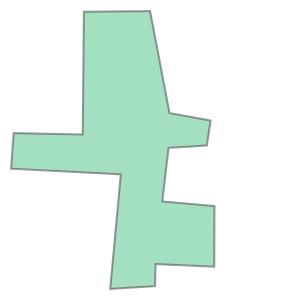

In [22]:
ex= path+'상습침수구역.shx'
gpff= gpd.read_file(ex)
gpff['geometry'][20]

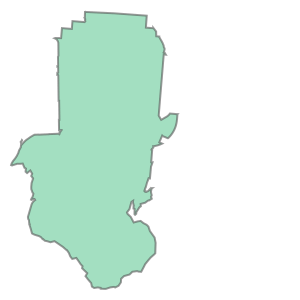

In [ ]:
gdf['geometry'][121]

In [6]:
apt= pd.read_csv('인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)


In [7]:
apt= apt[apt['legal_dong']=='부평동']

In [16]:
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
len(apt_points)


276

In [19]:
pwd

'c:\\Users\\chldy\\OneDrive\\바탕 화면\\용용\\딥러닝 부트캠프\\교육데이터공모전'

In [21]:
train= pd.read_csv('인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)

,Unnamed: 0,철도운영기관명,선명,역명,지번주소,도로명주소,위도경도,위도경도_text,lat,lon,legal_dong
0,0,인천교통공사,인천1호선,간석오거리,인천광역시 남동구 간석동 239-3,인천광역시 남동구 경인로 지하 642,"(126.708161076046, 37.4666459185412)","(126.708161076046, 37.4666459185412)",126.708161,37.466646,간석동
1,1,인천교통공사,인천1호선,갈산,인천광역시 부편구 청천동 112,인천광역시 부평구 부평대로 지하 286,"(126.721530626568, 37.5168167443412)","(126.721530626568, 37.5168167443412)",126.721531,37.516817,갈산동
2,2,인천교통공사,인천1호선,경인교대입구,인천광역시 계양구 계산동 1034,인천광역시 계양구 계양대로 지하 162,"(126.722600451556, 37.5380835631206)","(126.722600451556, 37.5380835631206)",126.722600,37.538084,계산동
3,3,인천교통공사,인천1호선,계산,인청광역시 계양구 계산동 1014,인천광역시 계양구 경명대로 지하 1089,"(126.728080590524, 37.5432900176718)","(126.728080590524, 37.5432900176718)",126.728081,37.543290,계산동
4,4,인천교통공사,인천1호선,계양,인천광역시 계양구 귤현동 451-264,인천광역시 계양구 다남로 24,"(126.736023400683, 37.5716093704302)","(126.736023400683, 37.5716093704302)",126.736023,37.571609,귤현동
...,...,...,...,...,...,...,...,...,...,...,...
63,63,인천교통공사,7호선,삼산체육관,NaN,경기도 부천시 길주로 713,NaN,"(126.741906601707, 37.5065825037123)",126.741907,37.506583,삼산동
64,64,인천교통공사,7호선,상동,NaN,경기도 부천시 길주로 104,"(126.75317777915, 37.5058133495726)","(126.75317777915, 37.5058133495726)",126.753178,37.505813,상동
65,65,인천교통공사,7호선,석남(거북시장),NaN,경기도 부천시 길주로 120,NaN,"(126.67459056506, 37.5062910033259)",126.674591,37.506291,석남동
66,66,인천교통공사,7호선,신중동,NaN,경기도 부천시 길주로 314,"(126.776490550411, 37.5029799729542)","(126.776490550411, 37.5029799729542)",126.776491,37.502980,중동


In [18]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 

m1= 0.311
m2= 0.088
m4= 0.601

In [ ]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    D = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D4 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j)*1000)
        D4.append(site)
    D4 = np.array(D4)

    for i in [D1, D2, D4]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3, x4 = {}, {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(D):                                       
        x4[i] = m.addVar(vtype=GRB.BINARY, name="x4%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(D): 
        m.addConstr(quicksum(y[j] for j in np.where(D4[i]==1)[0]) >= x4[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m4*x4[d] for d in range(D)]), GRB.MAXIMIZE)

#     # 목적함수 수정 v2.
#     res=[]
#     for a,b,c,d in zip_longest(range(A),range(B),range(C),range(D), fillvalue=0):
#         w1=m1;w2=m2;w3=m3;w4=m4
#         if a==b==c==d==0:
#             w1=m1;w2=m2;w3=m3;w4=m4
#         else:
#             if b==0:
#                 w2=0
#             if c==0:
#                 w3=0
#             if d==0:
#                 w4=0
#         res.append(w1*x1[a] + w2*x2[b] + w3*x3[c] + w4*x4[d])

#     m.setObjective(quicksum(i for i in res),GRB.MAXIMIZE)    

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [15]:
opts_sites, mobjVal = mclp(버스, 지하철,apt_points, 2, 1500)
opts_sites

  Number of points 276
  K 3
  Radius 1000
----- Output -----
  Running time : 0.18649601936340332 seconds
Optimal coverage points: 276


array([[ 37.4920485 , 126.71780272],
       [ 37.48701494, 126.72815092],
       [ 37.50471271, 126.72764499]])